In [1]:
from cropharvest.datasets import CropHarvest
from cropharvest.inference import Inference
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier

import requests
import tempfile

from cropharvest.datasets import Task, CropHarvest
from cropharvest.countries import get_country_bbox
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef
from typing import Dict, Optional
import pandas as pd
from typing import cast, List, Optional, Tuple, Generator
import pyproj
import rasterio
import rasterio.features
import shapely
import numpy as np

DATA_DIR = "./data"

#!mkdir $DATA_DIR
modelo=[]
accuracy_total=[]
auc_df=pd.DataFrame()
#accuracy_matthews=[]

In [2]:
evaluation_datasets = CropHarvest.create_benchmark_datasets(DATA_DIR, download=False)
evaluation_datasets

[CropHarvestEval(Kenya_1_maize, Kenya_maize),
 CropHarvestEval(Brazil_0_coffee, Brazil_coffee),
 CropHarvestEval(Togo_crop, togo-eval)]

In [11]:
my_dataset_p = CropHarvest(DATA_DIR,Task(bounding_box=get_country_bbox("Brazil")[0],normalize=True,geowiki=True))
X_testT,y_testT=my_dataset_p.as_array(flatten_x=True)

In [7]:
def sample_funcion(my_dataset_test, k: int, deterministic: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        # we will sample to get half positive and half negative
        # examples
        output_x: List[np.ndarray] = []
        output_y: List[np.ndarray] = []

        k = min(k, my_dataset_test.k)

        if deterministic:
            #print('420')
            pos_indices = my_dataset_test.positive_indices[:]
            neg_indices = my_dataset_test.negative_indices[:]##
            print(len(pos_indices), len(neg_indices))
        else:
            #print('line 424')
            pos_indices, my_dataset_test.sampled_positive_indices = sample_with_memory(
                my_dataset_test.positive_indices, k, my_dataset_test.sampled_positive_indices
            )
            neg_indices, my_dataset_test.sampled_negative_indices = sample_with_memory(
                my_dataset_test.negative_indices, k, my_dataset_test.sampled_negative_indices
            )

        # returns a list of [pos_index, neg_index, pos_index, neg_index, ...]
        indices = pos_indices+neg_indices#[val for pair in zip(pos_indices, neg_indices) for val in pair]
        #print('indices', len(indices))
        output_x, output_y = zip(*[my_dataset_test[i] for i in indices])

        x = np.stack(output_x, axis=0)
        return x, np.array(output_y)

In [8]:
dataset=evaluation_datasets[1]
len(dataset.filepaths)

4030

In [51]:
X_trainT,y_trainT= dataset.as_array(flatten_x=True)# X1 tiene un shape de (1290, 216), Y1 shape de (1290, 216)


In [54]:
y_trainT.shape

(4030,)

In [55]:
# Encuentra los índices únicos y los índices originales de los duplicados
unique_indices, original_indices = np.unique(X_trainT, axis=0, return_index=True)

# Filtra los arrays originales con los índices únicos
X_no_duplicates = X_trainT[original_indices]
Y_no_duplicates = y_trainT[original_indices]

# X_no_duplicates y Y_no_duplicates ahora contienen solo las entradas únicas
X_no_duplicates.shape

(1615, 216)

In [57]:
Y_no_duplicates.shape

(1615,)

In [33]:
X_trainT,y_trainT=sample_funcion(dataset,len(dataset.filepaths),deterministic=True)

21 4009


### CNN 2D

In [12]:
XTotal2=X_trainT.reshape(X_trainT.shape[0], 12, 18, 1)# shape (1290, 12, 18,1)
ytotal2=y_trainT.reshape(y_trainT.shape[0], 1)#(1290, 1)
X_test2=X_testT.reshape(X_testT.shape[0], 12,18, 1)
y_test2=y_testT.reshape(y_testT.shape[0], 1)

In [13]:
def evaluate_predictions_(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [14]:
def metrica_CNN(pais_modelo,y_test, y_pred):
  accuracy = fbeta_score(y_test, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_test,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_test, y_pred))
  #print('y_pred', y_pred)
  #print('y_test', y_test)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  

  results= evaluate_predictions_(pais_modelo,y_test,y_pred)
  
  print(results)

  return pais_modelo, accuracy * 100.0, cr, results,matthews_corrcoef(y_test, y_pred)

In [15]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D,Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

def CNN_model(x1,y1,pais_modelo,x_test,y_test,lr):
    #Forma de entrada para conv1D : (batch_size,W,channels)
    #Forma de entrada para conv2D : (batch_size,(H,W),channels)
    X_train, X_val, y_train, y_val = train_test_split(x1, y1, test_size=0.2, random_state=42)
    print('modelo CNN')
    model = Sequential()
    model.add(Conv2D(64, 3, activation='relu', input_shape=(x1.shape[1], x1.shape[2],1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar y entrenar el modelo
    print('entrenar el modelo')
    
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=200)
    mc = ModelCheckpoint(pais_modelo+'best_model_v2.h5', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)
    # fit model
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit( X_train, y_train,validation_data=(X_val, y_val), epochs=100, verbose=2, callbacks=[es, mc])
    print('len(X_train', len(X_train))
    print('len(X_val', len(X_val))
    print('len(X_test', len(x_test))
    # load the saved model
    saved_model = load_model(pais_modelo+'best_model_v2.h5')

    #model.fit(x1, y1, epochs=50, batch_size=32)
    
    #model.save('togo_v1.h5')
    


    y_pred_=model.predict(x_test)
    y_pred=y_pred_.reshape(y_pred_.shape[0])
    y_pred=y_pred.round()

    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)
    print(pais_modelo, accuracy , cr, results)
    print(results)
    print(model.summary())
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)
    print("matt coef")
    print(mt)
    return pais_modelo, accuracy , cr, results, mt

modelo CNN
entrenar el modelo
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.99380, saving model to Brazilbest_model_v2.h5
101/101 - 2s - loss: 0.6067 - accuracy: 0.9069 - val_loss: 0.5332 - val_accuracy: 0.9938 - 2s/epoch - 17ms/step
Epoch 2/100


c:\Users\henry\anaconda\envs\CH38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.99380
101/101 - 1s - loss: 0.4680 - accuracy: 0.9950 - val_loss: 0.4058 - val_accuracy: 0.9938 - 530ms/epoch - 5ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.99380
101/101 - 1s - loss: 0.3494 - accuracy: 0.9950 - val_loss: 0.2971 - val_accuracy: 0.9938 - 590ms/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.99380
101/101 - 1s - loss: 0.2516 - accuracy: 0.9950 - val_loss: 0.2111 - val_accuracy: 0.9938 - 628ms/epoch - 6ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.99380
101/101 - 1s - loss: 0.1773 - accuracy: 0.9950 - val_loss: 0.1495 - val_accuracy: 0.9938 - 541ms/epoch - 5ms/step
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.99380
101/101 - 1s - loss: 0.1261 - accuracy: 0.9950 - val_loss: 0.1089 - val_accuracy: 0.9938 - 520ms/epoch - 5ms/step
Epoch 7/100

Epoch 7: val_accuracy did not improve from 0.99380
101/101 - 1s - loss: 0.0923 - accuracy: 0.9950 - val_loss:

c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


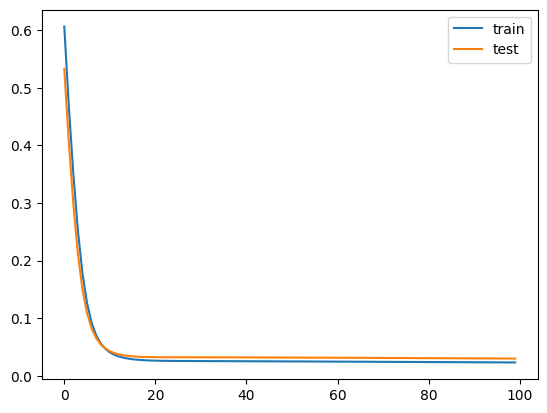

matthews_corrcoef 0.0
Accuracy: 42.87%
     Pais  auc_roc  f1_score  iou  num_samples
0  Brazil      0.5       0.0  0.0         1831
matt coef
0.0


c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
lr=0.00001
pais_modelo_T, accuracy_T , cr_T, results_T, mt=CNN_model(XTotal2,ytotal2,"Brazil",X_test2,y_testT,lr)

### CNN 1D 12_18

In [22]:
XTotal2=X_trainT.reshape(X_trainT.shape[0], 12, 18)
ytotal2=y_trainT.reshape(y_trainT.shape[0], 1)
X_test2=X_testT.reshape(X_testT.shape[0], 12, 18)
y_test2=y_testT.reshape(y_testT.shape[0], 1)
XTotal2.shape

(1301, 12, 18)

In [23]:
def evaluate_predictions_(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [24]:
def metrica_CNN(pais_modelo,y_test, y_pred):
  accuracy = fbeta_score(y_test, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_test,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_test, y_pred))
  #print('y_pred', y_pred)
  #print('y_test', y_test)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  

  results= evaluate_predictions_(pais_modelo,y_test,y_pred)
  
  print(results)

  return pais_modelo, accuracy * 100.0, cr, results,matthews_corrcoef(y_test, y_pred)

In [25]:
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D,Dropout
from keras.models import load_model
from matplotlib import pyplot


# Generar datos de ejemplo
#X_train = np.random.random((1000, 100, 1))
#y_train = np.random.randint(2, size=(1000, 1))

# Construir la arquitectura de la red CNN
def CNN_model(x1,y1,pais_modelo,x_test,y_test, lr):
    X_train, X_val, y_train, y_val = train_test_split(x1, y1, test_size=0.2, random_state=42)
    #Forma de entrada para conv1D : (batch_size,W,channels)
    #Forma de entrada para conv2D : (batch_size,(H,W),channels)
    print('modelo CNN')
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(x1.shape[1], x1.shape[2])))
    model.add(MaxPooling1D(2))
    
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar y entrenar el modelo
    print('entrenar el modelo')
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.fit(x1, y1, epochs=50, batch_size=32)
    
    #model.save('togo_v1.h5')
    es = EarlyStopping(monitor='accuracy', mode='min', verbose=2, patience=200)
    mc = ModelCheckpoint(pais_modelo+'_v1_best_model.h5', monitor='accuracy', mode='max', verbose=2, save_best_only=True)
    # fit model
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit( X_train, y_train,validation_data=(X_val, y_val), epochs=100, verbose=2, callbacks=[es, mc])
    #history = model.fit(x1[:round(x1.shape[0]*0.75)], y1[:round(x1.shape[0]*0.75)],validation_data=(x1[round(x1.shape[0]*0.75):], y1[round(x1.shape[0]*0.75):]), epochs=100, verbose=0, callbacks=[es, mc])
    # load the saved model
    saved_model = load_model(pais_modelo+'_v1_best_model.h5')

    print('len(X_train', len(X_train))
    print('len(X_val', len(X_val))
    print('len(X_test', len(x_test))


    y_pred_=model.predict(x_test)
    y_pred=y_pred_.reshape(y_pred_.shape[0])
    y_pred=y_pred.round()

    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)
    print(pais_modelo, accuracy , cr, results)
    print(results)
    print(model.summary())
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)

    return pais_modelo, accuracy , cr, results, mt


modelo CNN
entrenar el modelo
Epoch 1/100

Epoch 1: accuracy improved from -inf to 0.52981, saving model to Andino_v1_best_model.h5
33/33 - 1s - loss: 0.7575 - accuracy: 0.5298 - val_loss: 0.6857 - val_accuracy: 0.5900 - 1s/epoch - 38ms/step
Epoch 2/100

Epoch 2: accuracy improved from 0.52981 to 0.55288, saving model to Andino_v1_best_model.h5
33/33 - 0s - loss: 0.7449 - accuracy: 0.5529 - val_loss: 0.6759 - val_accuracy: 0.6092 - 128ms/epoch - 4ms/step
Epoch 3/100


c:\Users\henry\anaconda\envs\CH38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: accuracy did not improve from 0.55288
33/33 - 0s - loss: 0.7114 - accuracy: 0.5394 - val_loss: 0.6664 - val_accuracy: 0.6130 - 113ms/epoch - 3ms/step
Epoch 4/100

Epoch 4: accuracy improved from 0.55288 to 0.57115, saving model to Andino_v1_best_model.h5
33/33 - 0s - loss: 0.7198 - accuracy: 0.5712 - val_loss: 0.6597 - val_accuracy: 0.6398 - 130ms/epoch - 4ms/step
Epoch 5/100

Epoch 5: accuracy did not improve from 0.57115
33/33 - 0s - loss: 0.6977 - accuracy: 0.5625 - val_loss: 0.6529 - val_accuracy: 0.6398 - 165ms/epoch - 5ms/step
Epoch 6/100

Epoch 6: accuracy improved from 0.57115 to 0.57212, saving model to Andino_v1_best_model.h5
33/33 - 0s - loss: 0.6957 - accuracy: 0.5721 - val_loss: 0.6481 - val_accuracy: 0.6398 - 138ms/epoch - 4ms/step
Epoch 7/100

Epoch 7: accuracy improved from 0.57212 to 0.60865, saving model to Andino_v1_best_model.h5
33/33 - 0s - loss: 0.6734 - accuracy: 0.6087 - val_loss: 0.6449 - val_accuracy: 0.6437 - 146ms/epoch - 4ms/step
Epoch 8/100

Epoc

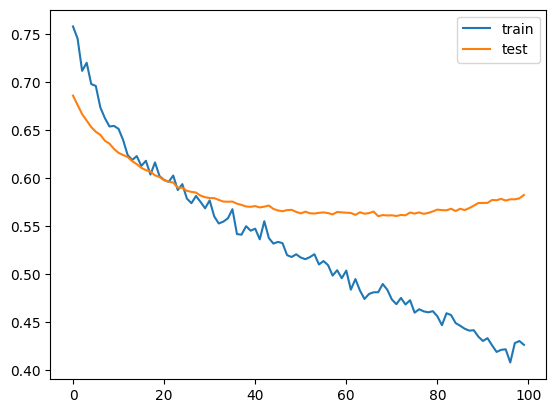

In [26]:
lr=0.0001
pais_modelo_T, accuracy_T , cr_T, results_T, mt=CNN_model(XTotal2,ytotal2,"Andino",X_test2,y_testT,lr)

### CNN 1D 216

In [27]:
XTotal2=X_trainT.reshape(X_trainT.shape[0], X_trainT.shape[1], 1)# shape (1290, 216, 1)
ytotal2=y_trainT.reshape(y_trainT.shape[0], 1)#(1290, 1)
X_test2=X_testT.reshape(X_testT.shape[0], X_testT.shape[1],1)
y_test2=y_testT.reshape(y_testT.shape[0], 1)

In [28]:
def evaluate_predictions_(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [29]:
def metrica_CNN(pais_modelo,y_test, y_pred):
  accuracy = fbeta_score(y_test, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_test,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_test, y_pred))
  #print('y_pred', y_pred)
  #print('y_test', y_test)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  

  results= evaluate_predictions_(pais_modelo,y_test,y_pred)
  
  print(results)

  return pais_modelo, accuracy * 100.0, cr, results

In [32]:
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D, Dropout
from keras.models import load_model
from matplotlib import pyplot

# Generar datos de ejemplo
#X_train = np.random.random((1000, 100, 1))
#y_train = np.random.randint(2, size=(1000, 1))

# Construir la arquitectura de la red CNN
def CNN_model(x1,y1,pais_modelo,x_test,y_test, lr):
    X_train, X_val, y_train, y_val = train_test_split(x1, y1, test_size=0.2, random_state=42)

    #Forma de entrada para conv1D : (batch_size,W,channels)
    #Forma de entrada para conv2D : (batch_size,(H,W),channels)
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(x1.shape[1], 1)))
    model.add(MaxPooling1D(2))
    
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar y entrenar el modelo
    es = EarlyStopping(monitor='accuracy', mode='min', verbose=2, patience=200)
    mc = ModelCheckpoint(pais_modelo+'_v0_best_model.h5', monitor='accuracy', mode='max', verbose=2, save_best_only=True)
    # fit model

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    #history = model.fit(x1[:round(x1.shape[0]*0.75)], y1[:round(x1.shape[0]*0.75)],validation_data=(x1[round(x1.shape[0]*0.75):], y1[round(x1.shape[0]*0.75):]), epochs=100, verbose=0, callbacks=[es, mc])
    history = model.fit( X_train, y_train,validation_data=(X_val, y_val), epochs=100, verbose=2, callbacks=[es, mc])
    # load the saved model
    saved_model = load_model(pais_modelo+'_v0_best_model.h5')

    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.fit(x1, y1, epochs=100, batch_size=32)

    y_pred=model.predict(x_test)
    y_pred=y_pred.reshape(y_pred.shape[0])
    y_pred=y_pred.round()

    print(model.summary())
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.show()


    pais_modelo, accuracy , cr, results=metrica_CNN(pais_modelo,y_test, y_pred)

    return pais_modelo, accuracy , cr, results

Epoch 1/100

Epoch 1: accuracy improved from -inf to 0.61827, saving model to Andino_v0_best_model.h5
33/33 - 1s - loss: 0.6696 - accuracy: 0.6183 - val_loss: 0.6438 - val_accuracy: 0.6820 - 1s/epoch - 39ms/step
Epoch 2/100


c:\Users\henry\anaconda\envs\CH38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: accuracy improved from 0.61827 to 0.66346, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.6340 - accuracy: 0.6635 - val_loss: 0.6192 - val_accuracy: 0.6897 - 400ms/epoch - 12ms/step
Epoch 3/100

Epoch 3: accuracy improved from 0.66346 to 0.68077, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.6041 - accuracy: 0.6808 - val_loss: 0.6013 - val_accuracy: 0.6858 - 420ms/epoch - 13ms/step
Epoch 4/100

Epoch 4: accuracy improved from 0.68077 to 0.69519, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.5791 - accuracy: 0.6952 - val_loss: 0.5792 - val_accuracy: 0.6858 - 400ms/epoch - 12ms/step
Epoch 5/100

Epoch 5: accuracy improved from 0.69519 to 0.71731, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.5613 - accuracy: 0.7173 - val_loss: 0.5655 - val_accuracy: 0.6897 - 401ms/epoch - 12ms/step
Epoch 6/100

Epoch 6: accuracy improved from 0.71731 to 0.72212, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.5442 - accurac

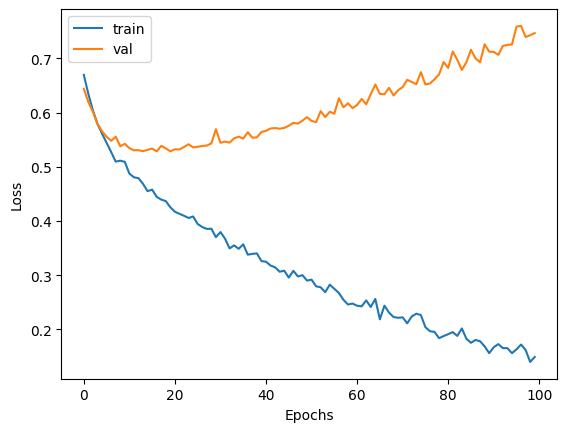

matthews_corrcoef 0.4185200951995831
Accuracy: 71.04%
     Pais   auc_roc  f1_score       iou  num_samples
0  Andino  0.711097  0.735376  0.581498          328


In [33]:
lr=0.0001
pais_modelo_T, accuracy_T , cr_T, results_T=CNN_model(XTotal2,ytotal2,"Andino",X_test2,y_testT,lr)

### RANDOM FOREST

In [41]:
paises=['Brazil','Peru', "Argentina", "Bolivia","Ecuador"]
index_pais=[0,1,2,3,4]

In [17]:
def evaluate_predictions_funcion(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [18]:
def datos_XT_solo(B,C,index_B):
  

  model = RandomForestClassifier(random_state=0)
  model.fit(B, C)

  y_pred = model.predict(X_testT)
  accuracy = fbeta_score(y_testT, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_testT,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_testT, y_pred))
  print('y_pred', y_pred)
  print('y_test', y_testT)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  
  pais_modelo=[]
  for i in index_B:
    #print(i)
    pais_modelo.append(paises[i])
    print(paises[i])
    #paises[0:1]
  print('aqui')
  results= evaluate_predictions_funcion(pais_modelo,y_testT,y_pred)
  print(results)
  return pais_modelo, accuracy * 100.0, cr, results

In [24]:
X_trainT.shape

(4030, 12, 18)

In [43]:
pais_modelo,accuracy_, cr_T, aucr=datos_XT_solo(X_trainT,y_trainT,index_pais)
auc_df=aucr
modelo.append(pais_modelo)
accuracy_total.append(accuracy_)
print(cr_T)

matthews_corrcoef 0.0
y_pred [0 0 0 ... 0 0 0]
y_test [1 1 1 ... 0 0 0]
Accuracy: 42.87%
Colombia
Peru
Argentina
Bolivia
Ecuador
aqui
                                            Pais  auc_roc  f1_score  iou  \
0  [Colombia, Peru, Argentina, Bolivia, Ecuador]      0.5       0.0  0.0   

   num_samples  
0         1831  
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       785
           1       0.00      0.00      0.00      1046

    accuracy                           0.43      1831
   macro avg       0.21      0.50      0.30      1831
weighted avg       0.18      0.43      0.26      1831



c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry\anaconda\envs\CH38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
